# [4.2] k-최근접 이웃 (k-Nearest Neighbor, kNN) 알고리즘

- 지도학습 알고리즘 > '분류'에 이용

## 이론


> 기존의 Data 안에서 현재 Data로부터 가까운 k개의 Data를 찾아 k개의 레이블 중 가장 많이 분류된 값으로 현재의 Data를 분류하는 알고리즘


이때 **'k'**는 몇 개의 가까운 Data를 찾을 것인지를 나타내는 변수 (홀수로 지정하는 것이 좋다! 과반수의 결과를 얻기 위함!)


'k'에 따라서 결국 Data가 다르게 예측되는 것인데, 그 최적의 'k'값을 찾는 것이 중요!


그럴려면 검증을 통해서 가장 정확도가 높은 'k'를 찾아서 사용해야한다.


즉, 거리를 측정해서 가까운 Data를 찾는 것인데, 이때 머신러닝에서는 **벡터 공간**을 사용한다.


- 이중 분류는 2차원 벡터 공간을, 다중 분류에서는 n차원 벡터 공간을 사용함.
- 다중 분류의 경우, 4차원 이상이면 시각화는 힘들지만 알고리즘 상에서는 문제 없음!


- 우리가 흔히 알고있는 '피타고라스의 방식'으로 Data 간의 거리를 구하게 된다.


- 2차원이 아니어도 거리를 구하는 방식은 n차원으로 늘어나도 동일하기 때문에 거리 계산은 가능하다.


　



　


## 장/단점


### 장점



- 거리를 구하는 방식을 사용 -> 즉, 숫자로 된 Data에 사용하면 높은 정확도를 기대할 수 있음.
- 예측 시점에서 Data가 주어지면 바로 기존 Data와의 거리를 계산하기 때문에 미리 모델 학습을 할 필요가 없음. -> 실시간 Data 사용에 유리
- 이러한 특성을 게으른 학습(Lazy Learning)이라고 함!


### 단점


- 한 가지의 Data를 예측할 때, 모든 Data와의 거리를 계산 -> 속도가 느리고, 메모리 사용 多
- 예측 값이 주변 정보에 의해서 많이 편향될 가능성 있음(미리 학습된 모델이 아니라 가까운 이웃 Data로만 예측하기 때문)

## 예제) 농구선수의 게임 데이터를 활용한 포지션 예측

### Data 살펴보기

In [1]:
import os

os.getcwd()
os.chdir('/workspace/DS033')

In [2]:
import pandas as pd

df = pd.read_csv('DS060/data/csv/basketball_stat.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  100 non-null    object 
 1   Pos     100 non-null    object 
 2   3P      100 non-null    float64
 3   2P      100 non-null    float64
 4   TRB     100 non-null    float64
 5   AST     100 non-null    float64
 6   STL     100 non-null    float64
 7   BLK     100 non-null    float64
dtypes: float64(6), object(2)
memory usage: 6.4+ KB


In [3]:
df.head()

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


In [4]:
df.value_counts('Pos')

Pos
SG    50
C     50
dtype: int64

| 약어 | 설명 |
|:----|:----|
| Player | 선수 이름 |
| Pos | 포지션 |
| 3P | 한 경기 평균 3점슛 성공 횟수 |
| 2P | 한 경기 평균 2점슛 성공 횟수 |
| TRB | 한 경기 평균 리바운드 성공 횟수 |
| AST | 한 경기 평균 어시스트 성공 횟수 |
| STL | 한 경기 평균 스틸 성공 횟수 |
| BLK | 한 경기 평균 블로킹 성공 횟수 |


포지션 설명


- C : 센터; **블로킹**, **리바운드** 역할, 공을 바깥으로 빼서 공격 찬스를 만들기도 하고, 골대 근처에서 2점슛으로 득점도 함.
- SG : 슈팅가드; **3점슛** 등 장거리에서 슛을 해서 점수를 얻는 역할을 함.


두 포지션을 구분할 수 있는 속성으로 '블로킹', '리바운드', '3점슛'을 선정.


가설일 뿐이니까 가설의 사실을 입증해야 함. -> **데이터 시각화**가 좋은 수단 중 하나!

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'STL and 2P in 2d Plane')

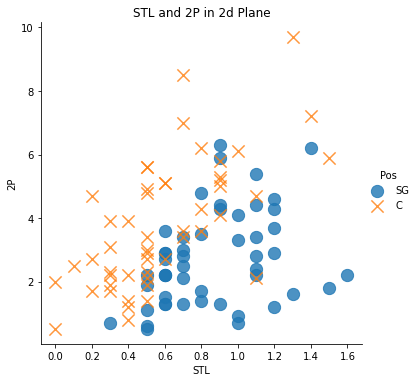

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns  # Matplotlib을 기반으로 하고 다양한 기능을 추가한 시각화 패키지 
%matplotlib inline
# Notebook 안에서 코드 실행 결과(그림)을 볼 수 있도록 해주는 매직 커맨드


sns.lmplot('STL', '2P', data = df, fit_reg = False, # True인 경우 추세선이 그려짐
          scatter_kws = {'s':150}, # 좌표 상의 점 크기 조절
          markers = ['o', 'x'],
          hue = 'Pos') # 점을 찍고 싶은 변수 (예측값)

plt.title('STL and 2P in 2d Plane')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'AST and 2P in 2d Plane')

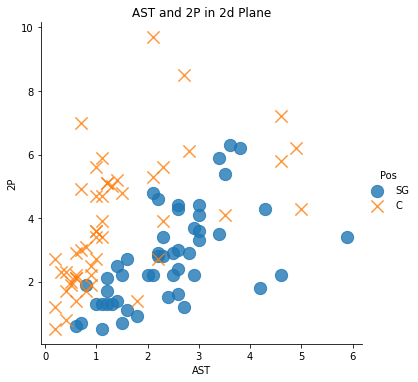

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns  # Matplotlib을 기반으로 하고 다양한 기능을 추가한 시각화 패키지 
%matplotlib inline
# Notebook 안에서 코드 실행 결과(그림)을 볼 수 있도록 해주는 매직 커맨드


sns.lmplot('AST', '2P', data = df, fit_reg = False, # True인 경우 추세선이 그려짐
          scatter_kws = {'s':150}, # 좌표 상의 점 크기 조절
          markers = ['o', 'x'],
          hue = 'Pos') # 점을 찍고 싶은 변수 (예측값)

plt.title('AST and 2P in 2d Plane')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'BLK and 3P in 2d Plane')

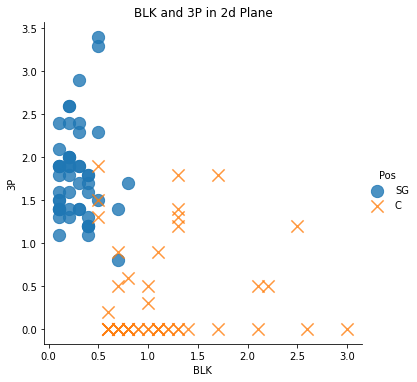

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns  # Matplotlib을 기반으로 하고 다양한 기능을 추가한 시각화 패키지 
%matplotlib inline
# Notebook 안에서 코드 실행 결과(그림)을 볼 수 있도록 해주는 매직 커맨드


sns.lmplot('BLK', '3P', data = df, fit_reg = False, # True인 경우 추세선이 그려짐
          scatter_kws = {'s':150}, # 좌표 상의 점 크기 조절
          markers = ['o', 'x'],
          hue = 'Pos') # 점을 찍고 싶은 변수 (예측값)

plt.title('BLK and 3P in 2d Plane')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TRB and 3P in 2d Plane')

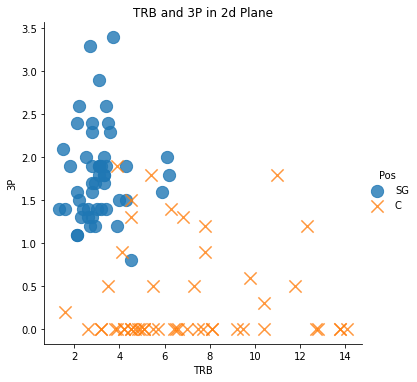

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns  # Matplotlib을 기반으로 하고 다양한 기능을 추가한 시각화 패키지 
%matplotlib inline
# Notebook 안에서 코드 실행 결과(그림)을 볼 수 있도록 해주는 매직 커맨드


sns.lmplot('TRB', '3P', data = df, fit_reg = False, # True인 경우 추세선이 그려짐
          scatter_kws = {'s':150}, # 좌표 상의 점 크기 조절
          markers = ['o', 'x'],
          hue = 'Pos') # 점을 찍고 싶은 변수 (예측값)

plt.title('TRB and 3P in 2d Plane')

4가지 모두 Data의 구분이 확실하지 않음(경계가 너무 근접해서 분류하기 모호) -> 가설이 타당해보임!

### Data 다듬기


분류하는데 도움이 되지 않는 특징('2점슛(2P)', '어시스트(AST)', '스틸(STL)')은 제거

In [9]:
df.drop(['2P', 'AST', 'STL'], axis = 1, inplace = True)
# 'inplace = True' : 함수 실행 후 반환되는 객체를 바로 df로 사용하겠다는 의미
# default 값은 'inplace = False'

In [10]:
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


### Data 나누기


사이킷런의 'train_test_split'을 이용하여 학습 Data와 테스트 Data로 분리.

In [11]:
from sklearn.model_selection import train_test_split

In [23]:
train, test = train_test_split(df, test_size = 0.2)  # 테스트 Data의 비율이 20%가 되도록 설정

# 'test_size = 0.2' = 'train_size = 0.8'

In [13]:
type(train)  # split한 Data의 type은 Pandas의 DataFrame

pandas.core.frame.DataFrame

In [14]:
train.info()  # 80개의 Data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 9 to 92
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  80 non-null     object 
 1   Pos     80 non-null     object 
 2   3P      80 non-null     float64
 3   TRB     80 non-null     float64
 4   BLK     80 non-null     float64
dtypes: float64(3), object(2)
memory usage: 3.8+ KB


In [15]:
test.info()  # 20개의 Data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 81 to 95
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  20 non-null     object 
 1   Pos     20 non-null     object 
 2   3P      20 non-null     float64
 3   TRB     20 non-null     float64
 4   BLK     20 non-null     float64
dtypes: float64(3), object(2)
memory usage: 960.0+ bytes


train 변수에는 train Data가, test 변수에는 test Data가 원래의 df에서 각각 80%, 20%의 비율로 나누어졌음.

### 최적의 'k'값 찾기

방법은 여러가지가 있음!


1. `train_test_split()`을 이용해 Data 나눔 -> 검증 Data의 레이블 vs kNN 알고리즘 모델 예측값 비교
2. 사이킷런의 `cross_val_score()`을 이용 (**책에서는 이 방법을 이용함.**)


`cross_val_score()`을 이용하면 쉽게 kNN 모델의 교차 검증을 수행할 수 있음!


이때 교차 검증은 **'k-fold 교차 검증'**!


> 'k-fold' 교차 검증이란,
>> 기존 Data를 k개로 나누고, k개로 나눠진 Data를 모두 검증 Data로 한 번씩 사용함. 이렇게 k번 검증을 하고 이때의 정확도들을 평균내는 방식.




In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


max_k_range = train.shape[0] // 2
k_list = []
for i in range(3, max_k_range, 2):
    k_list.append(i)
    
cross_validation_scores = []
x_train = train[['3P', 'BLK', 'TRB']]
y_train = train[['Pos']]


for k in k_list:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), cv = 10, scoring = 'accuracy')
    cross_validation_scores.append(scores.mean())
    
cross_validation_scores

[0.875,
 0.8875,
 0.9125,
 0.925,
 0.9,
 0.9,
 0.9125,
 0.8875,
 0.8875,
 0.875,
 0.875,
 0.8625,
 0.8375,
 0.8125,
 0.8125,
 0.8125,
 0.8125,
 0.8125,
 0.8]

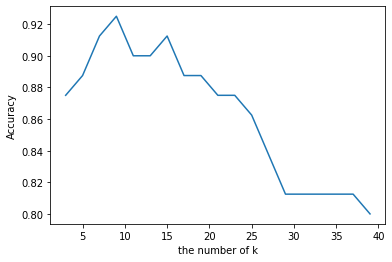

In [25]:
# k에 따른 정확도를 그래프로 시각화

plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.show()

In [26]:
type(cross_validation_scores)

list

In [27]:
k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print('The best number of k : {}'.format(k))

The best number of k : 9


### 모델 테스트

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors = k)  # 위에서 구한 최적의 'k'값이 지정됨

x_train = train[['3P', 'BLK', 'TRB']]
y_train = train[['Pos']]

knn.fit(x_train, y_train.values.ravel())  # kNN 모델 학습

x_test = test[['3P', 'BLK', 'TRB']]
y_test = test[['Pos']]

pred = knn.predict(x_test)  # 테스트 시작 -> 결과를 'pred' 변수에 저장 (array type)

print('accuracy : {}'.format(accuracy_score(y_test.values.ravel(), pred)))

accuracy : 0.9


In [33]:
comparison = pd.DataFrame({'prediction':pred, 'ground_truth':y_test.values.ravel()})
comparison

# 'prediction'은 예측값, 'ground_truth'는 실제값

,prediction,ground_truth
0,SG,SG
1,SG,SG
2,C,C
3,SG,C
4,SG,SG
5,SG,SG
6,C,C
7,C,C
8,SG,SG
9,C,C


'k'값이나, 정확도(accuracy)나 코드를 실행할 때마다 다르게 측정된다.


랜덤으로 테스트 Data와 훈련 Data가 나누어지다 보니 그런 것 같다.